# **Pairs Trading**

Pairs Trading is a market-neutral trading strategy which involves matching a long position with a short position in two securities which have a high level of positive correlation. It is a form of **statistical arbitrage** i.e it looks at the relative price movement between the two securities.

As it is a market-neutral strategy, it is independent of the trend being followed by the overall market (upwards or downwards). Instead, pairs trading works on the concept of mean-reversion. When two highly correlated securites deviate from their general trend, it is expected that they will return back to that trend in the future.

The spread between the stock prices created during the deviation serves as an opportunity for profit. One can open a long position on the stock expected to move upwards and a short position on the stock expected to move downwards. If the pair performs as expected, it is a profitable trade.

Even if the pair does not perform as expected, the trader will be able to mitigate some portion of their losses as the loss on one security will be offset by the profits on the other security. Hence, pairs trading also acts as a form of hedging and can be used to minimise losses.

## **Importing Libraries**

In [197]:
!pip install yfinance

In [198]:
!pip install pandas_ta


In [199]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller
import pandas_ta as ta
import statsmodels
import statsmodels.api as sm

## **Importing Stock Price dataset**

For the purpose of this strategy, a lookback period of four years from June 2017-2020 will be used to identify stock pairs having high positive correlation. In particular, stocks from the banking sector will be considered and hence the stocks of the BANK NIFTY index have been taken.


In [200]:
start_date = "2017-6-1"
end_date = "2020-6-1"

stocks = ["ULTRACEMCO.NS", "SHREECEM.NS"]


In [201]:
stock_data =  yf.download(stocks, start = start_date ,end= end_date)['Adj Close']
stock_data.head()


[*********************100%%**********************]  2 of 2 completed


,SHREECEM.NS,ULTRACEMCO.NS
Date,,
2017-06-01,17246.240234,4090.600342
2017-06-02,17544.080078,4131.766602
2017-06-05,18191.107422,4070.919189
2017-06-06,17727.845703,4016.697266
2017-06-07,17658.050781,4034.478516


## **Identifying stock pairs**

**FINDING COEFFICIENT OF CORRELATION**

In [202]:
corr_matrix = stock_data.corr()
corr_matrix


,SHREECEM.NS,ULTRACEMCO.NS
SHREECEM.NS,1.000000,0.599728
ULTRACEMCO.NS,0.599728,1.000000


<Axes: >

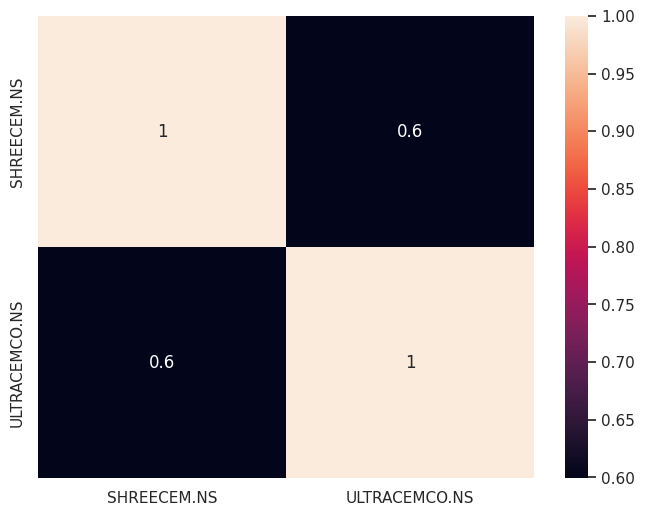

In [203]:
import seaborn as sn
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sn.heatmap(corr_matrix, annot = True)


### **Cointegration**

Cointegration is a statistical method which is used to identify the correlation between two non-stationary time series in the long run or over a specified period.

**Finding stock pairs with cointegrated time series:**

In [204]:
def cointegration_test(stock_data, stocks):
    N = stock_data.shape[1]
    pvalues = np.ones((N, N))
    stock_pairs = []

    for i in range(N):
      for j in range(N):
        if i == j:
          continue

        result = coint(stock_data[stocks[i]], stock_data[stocks[j]])
        pval = result[1]
        pvalues[i][j] = pval

        if(pval < 0.05 and stocks[i] != stocks[j]):                   # Cutoff threshold for 95% confidence
          stock_pairs.append((pval, (stocks[i], stocks[j])))

    return pvalues, stock_pairs


<Axes: >

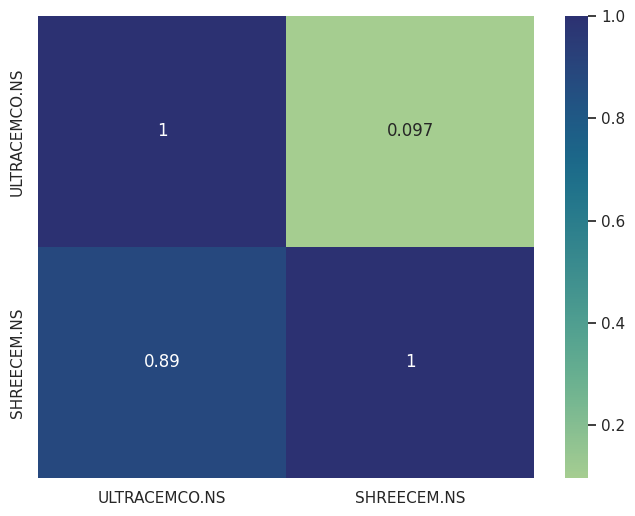

In [205]:
pvalues, stock_pairs = cointegration_test(stock_data, stocks)
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalues, xticklabels = stocks, yticklabels = stocks, cmap = 'crest',  annot = True)


The pairs of stocks having a cointegration are those with a p-value less than the threshold of 0.05.
P-value can be considered as a measure of the strength of cointegration between the two series. A lower p-value indicates a stronger cointegration

ADF test

In [206]:
from statsmodels.tsa.stattools import adfuller
#We will compute ADF test to check stationary signals for -
# 1. ULtracemco & shreecement
ULTRACEMCO = stock_data['ULTRACEMCO.NS']
SHREECEM = stock_data['SHREECEM.NS']

ULTRACEMCO_ADF = adfuller(ULTRACEMCO)
print('P value for the Augmented Dickey-Fuller Test is(ULTRACEM)', ULTRACEMCO_ADF[1])
SHREECEM_ADF = adfuller(SHREECEM)
print('P value for the Augmented Dickey-Fuller Test is(SHREECEM)', SHREECEM_ADF[1])
Spread_ADF = adfuller(ULTRACEMCO - SHREECEM)
print('P value for the Augmented Dickey-Fuller Test is(SPREAD)', Spread_ADF[1])
Ratio_ADF = adfuller(ULTRACEMCO / SHREECEM)
print('P value for the Augmented Dickey-Fuller Test is(RATIO)', Ratio_ADF[1])
# Spread looks fine. If you'd want even better results, consider taking the difference (order 1) of Berkshire and MSFT

# Results: can only claim stationary for the spread (since P value < 0.05). This suggests a constant mean over time.
# Therefore, the two series are cointegrated.


P value for the Augmented Dickey-Fuller Test is(ULTRACEM) 0.0048877349684708915
P value for the Augmented Dickey-Fuller Test is(SHREECEM) 0.2417796164830024
P value for the Augmented Dickey-Fuller Test is(SPREAD) 0.3214642131150155
P value for the Augmented Dickey-Fuller Test is(RATIO) 0.6699631129072865


ADF test fails for all cases for Kotak & HDFC

ADF test is successful i.e p value< 0.05 for spread and ratio value for Federal
bank and IDFC\

**Selected pair: FEDERALBNK Bank & IDFC Bank**

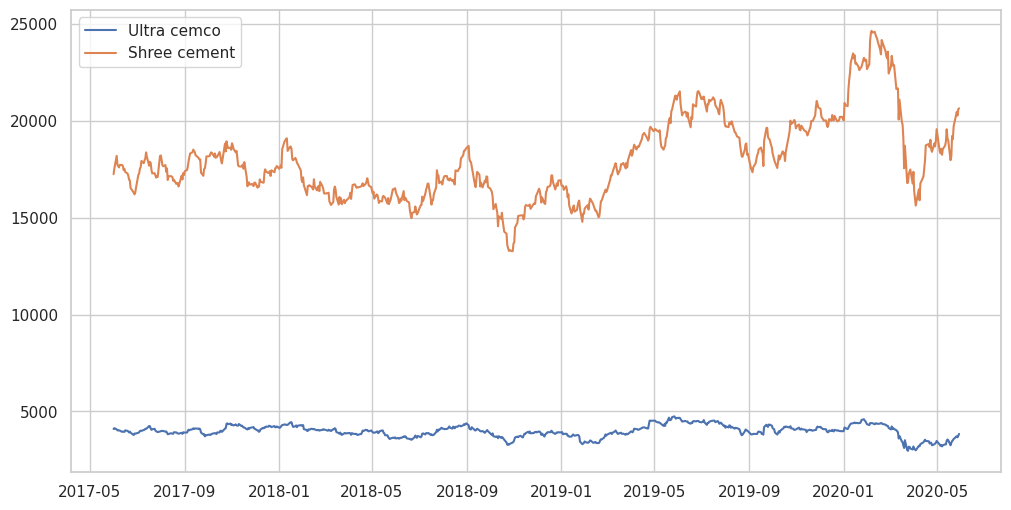

In [207]:
plt.figure(figsize = (12, 6))
plt.plot(stock_data['ULTRACEMCO.NS'], label = 'Ultra cemco')
plt.plot(stock_data['SHREECEM.NS'], label = 'Shree cement')
plt.legend()
plt.show()

### **Testing Data**

* The strategy will use a 3 year testing period fron July 2020 to July 2023. The ratio between the 2 stock prices will be used to determine points of entry and exit for the pairs trade.

[*********************100%%**********************]  2 of 2 completed


Text(0.5, 1.0, 'Price Ratio between ultracem and shreecem')

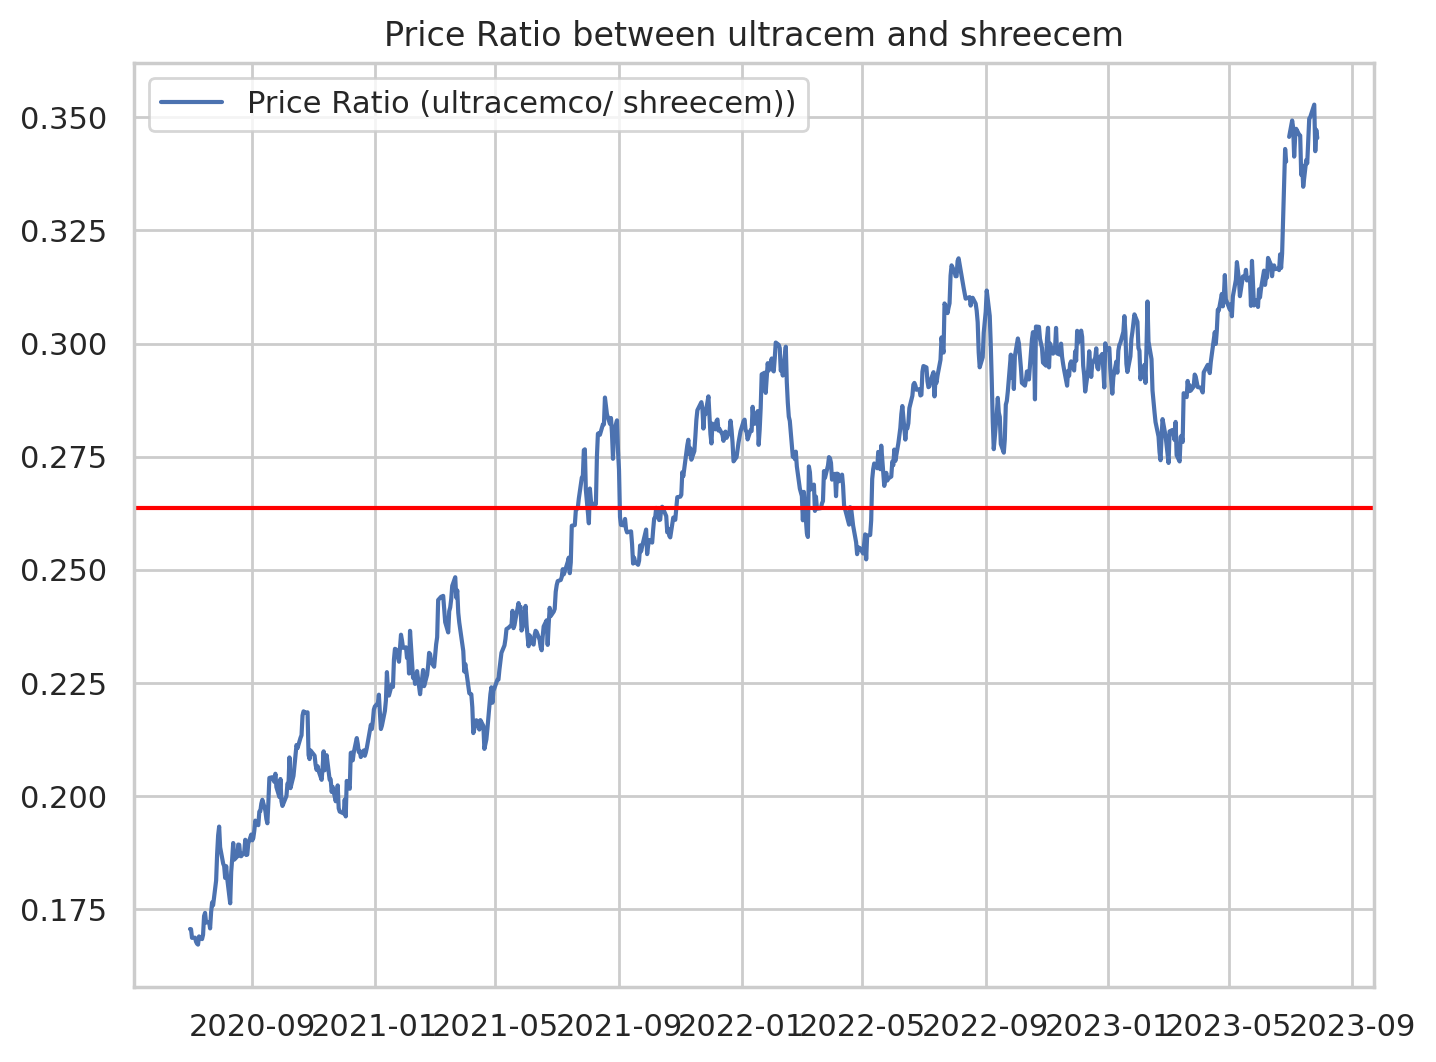

In [208]:
import yfinance as yf
import statsmodels.api as sm

# Also, we can take a look at the price ratios between the two time series.
#changing timeframe
start_date1 = "2020-7-1"
end_date1 = "2023-7-31"
stock_data1 =  yf.download(stocks, start = start_date1 ,end= end_date1)['Adj Close']
figure(figsize=(8, 6), dpi=200)
ratio = stock_data1['ULTRACEMCO.NS'] / stock_data1['SHREECEM.NS']
plt.plot(ratio, label = 'Price Ratio (ultracemco/ shreecem))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between ultracem and shreecem")


## **Z-Score**

A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. Z-scores also make it possible to adapt values from data sets having a very different ranges to make scores that are comparable.
Essentially, z-scores can shrink a large range of values into a much smaller range which is easier to handle.

Zscore.svg

𝒳 = series

μ = series mean

σ = series standard deviation

z-score for RATIO

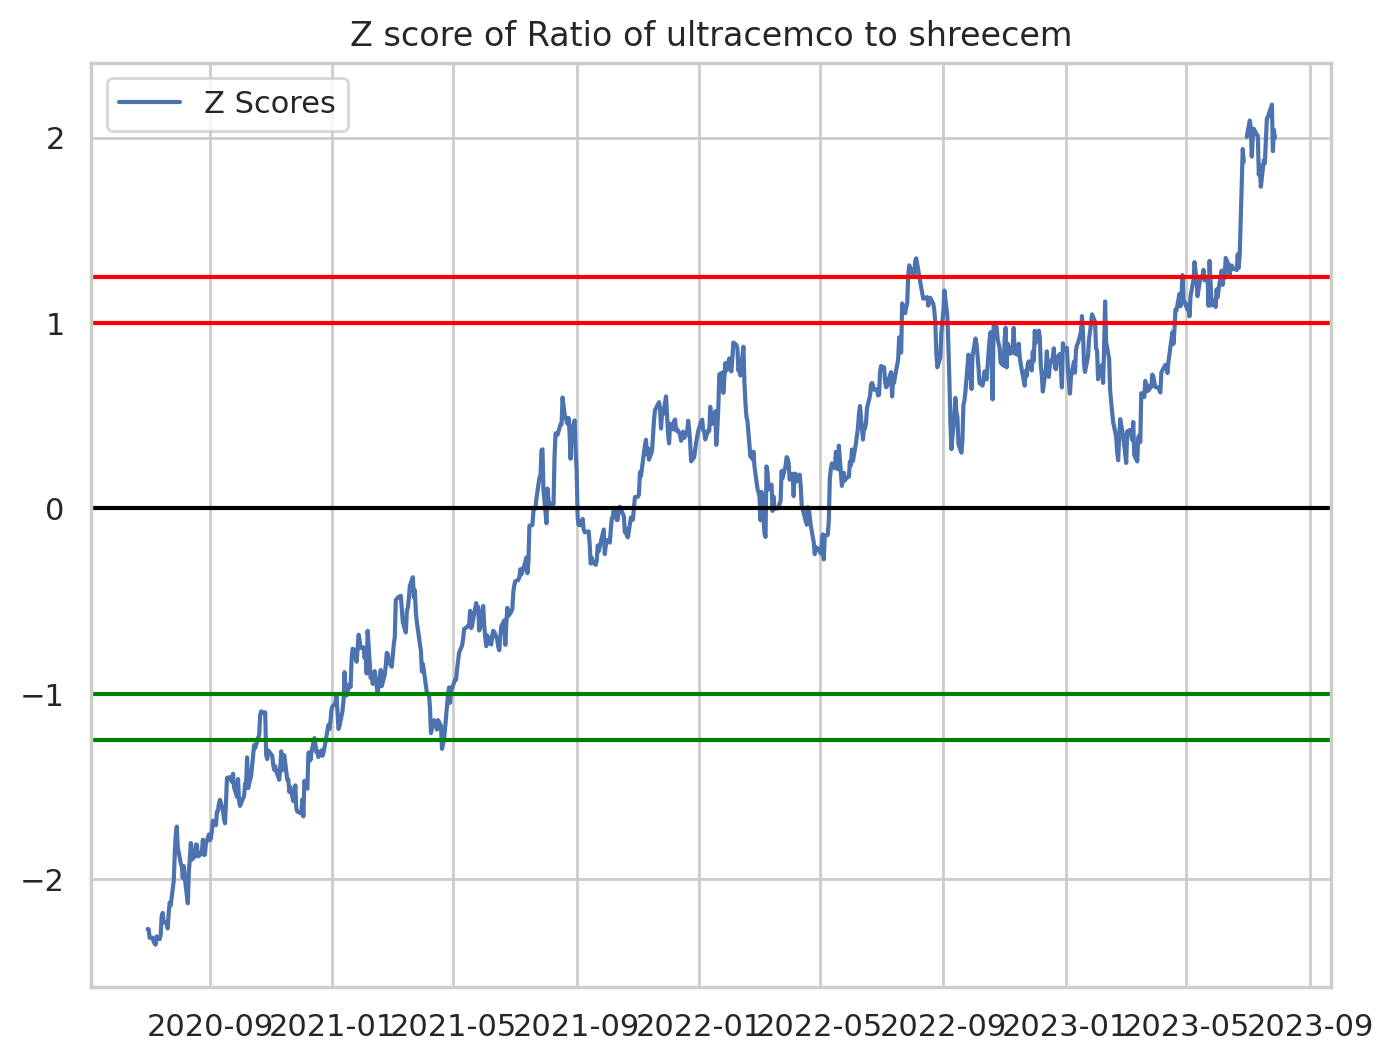

In [209]:
# NOTE, here you can either use the spread OR the Price ratio approach. Anyways, let's standardize the ratio so we can have a
# upper and lower bound to help evaluate our trends.. Let's stick with the ratio data.
figure(figsize=(8, 6), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of ultracemco to shreecem')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can
# determine when you can go long or short the pair (BRK_B to MSFT).



## **Trading Strategy**

Implementation of a simple mean-reversion based strategy. The threshold levels for the Z-score are taken as +1 and -1. Whenever the Z-score value rises above +1, it is expected to fall in the future and a short position is taken on the pair. Similarly, when the Z-score value falls below -1, it is expected to rise in the future and a long position is taken on the pair.


Signals for Ratio

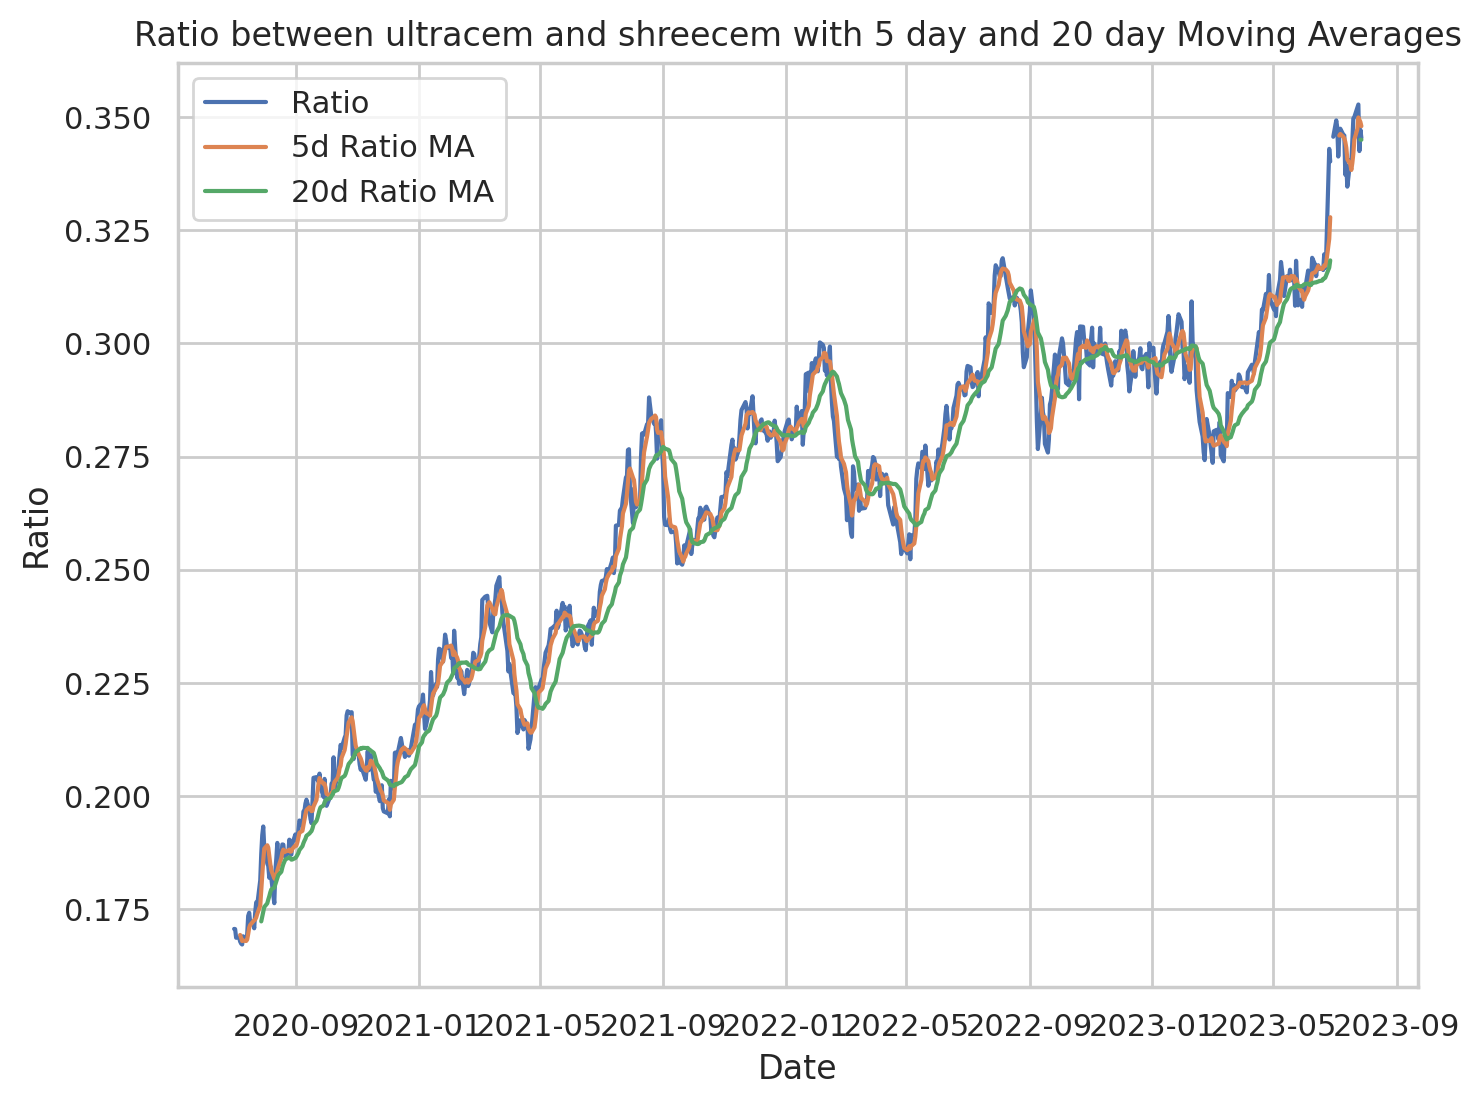

In [210]:
figure(figsize=(8, 6), dpi=200)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between ultracem and shreecem with 5 day and 20 day Moving Averages')
plt.show()


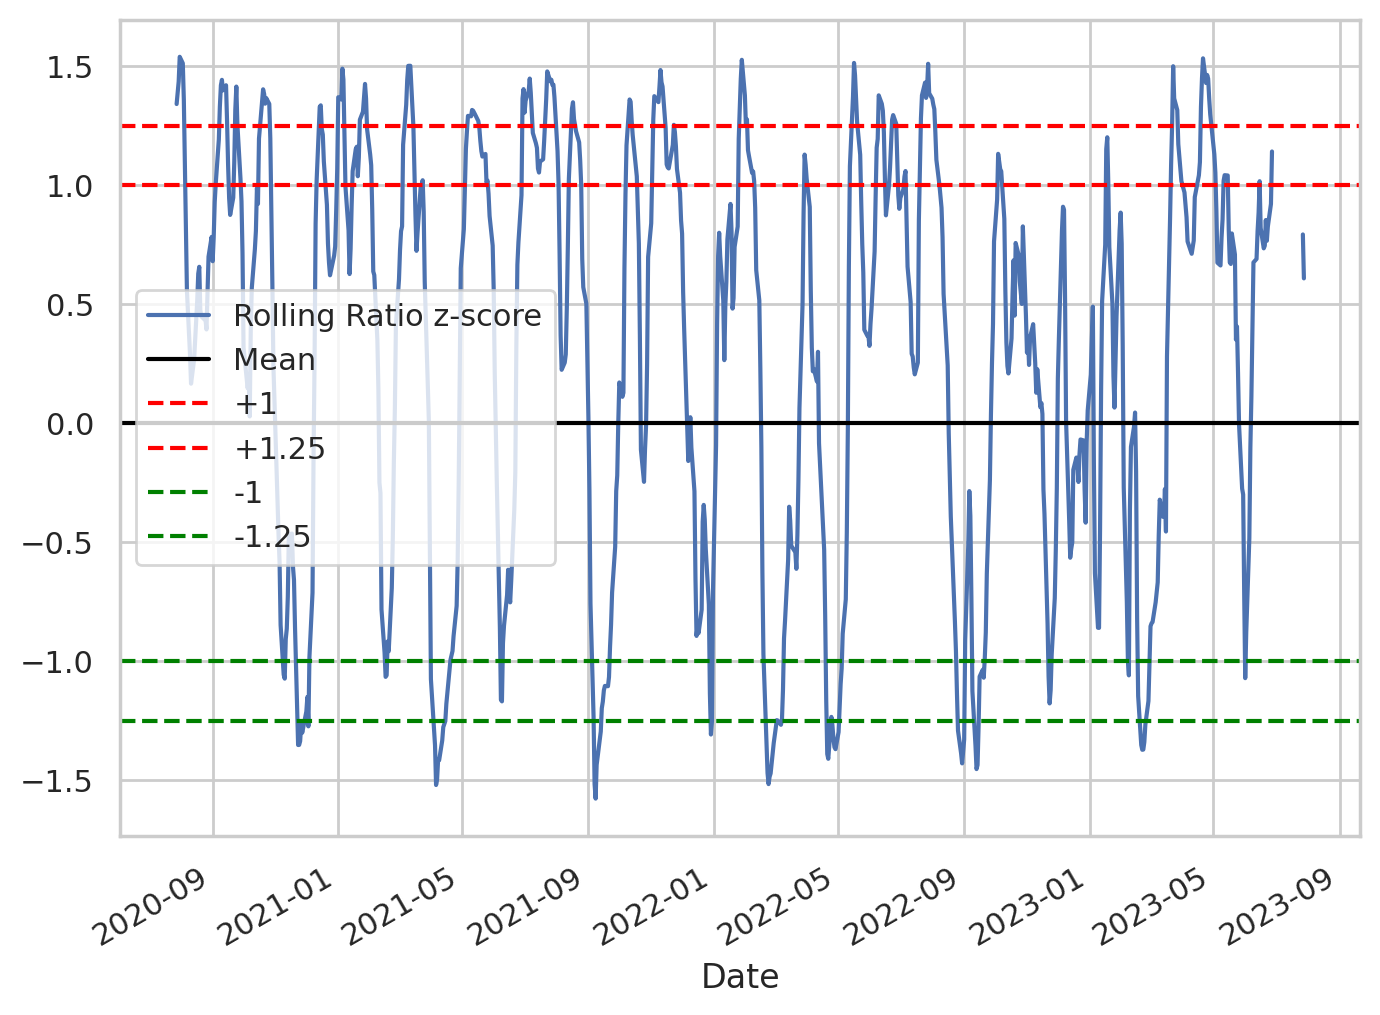

In [211]:
figure(figsize=(8, 6), dpi=200)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()


### **Visualising the positions**

**1) Trades on the pair**

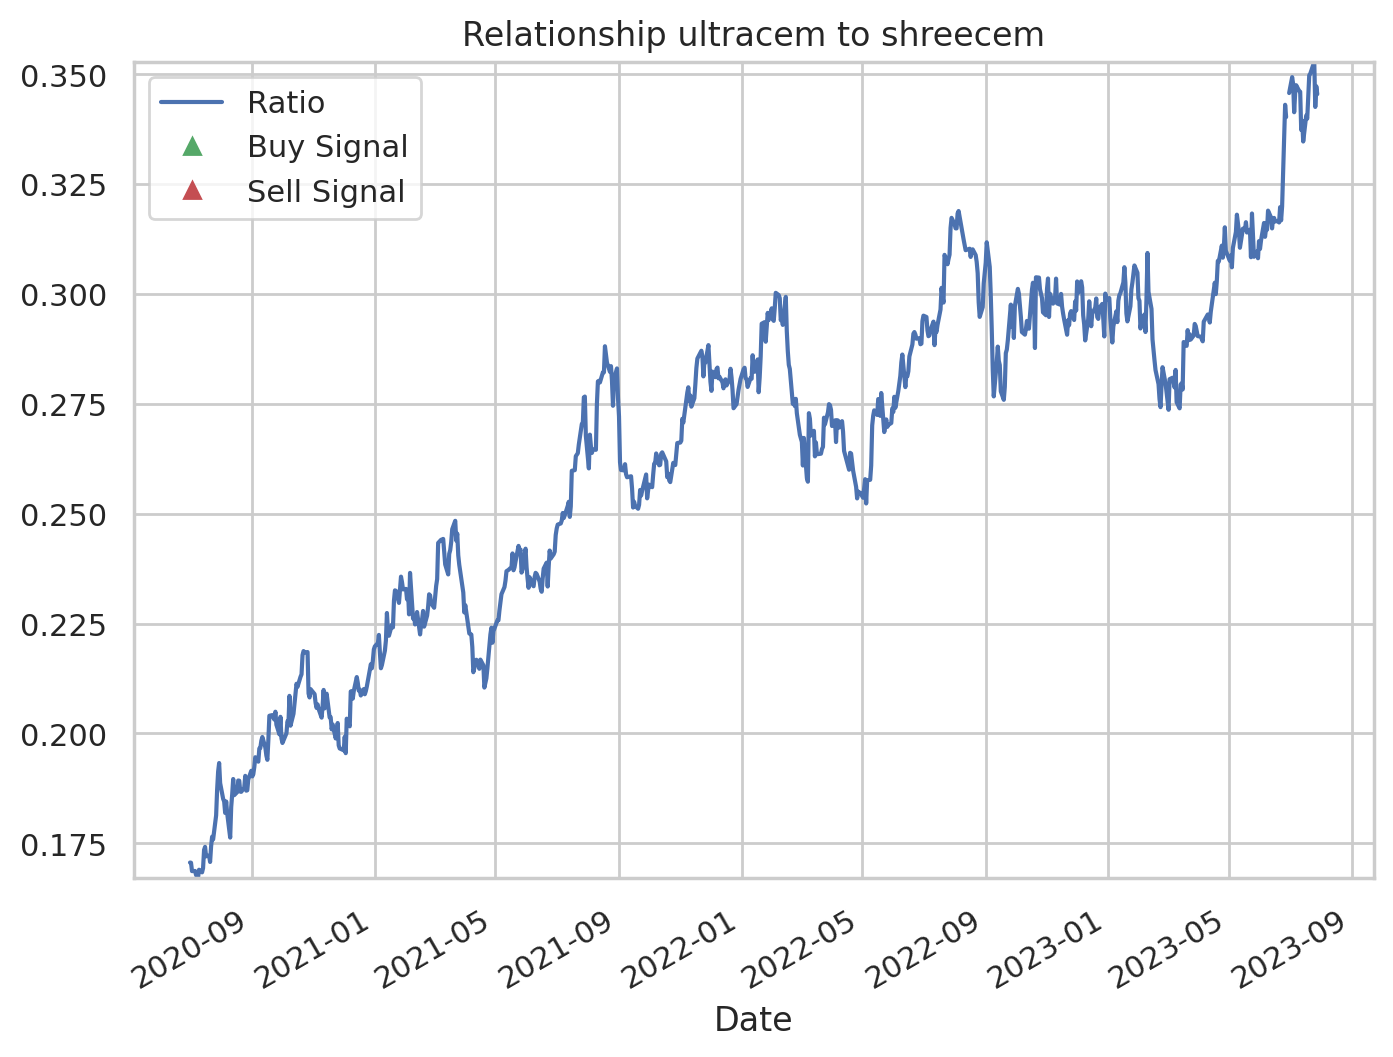

In [212]:
figure(figsize=(8, 6), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 1
sell[zscore_20_5<1] = -1


# signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
#   signals['position1'] = signals['signal1'].diff()
#   signals['signal2'] = -signals['signal1']
#   signals['position2'] = signals['signal2'].diff()


buysig = buy.diff()
sellsig = sell.diff()
buy.diff().plot(color='g', linestyle='None', marker='^')
sell.diff().plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship ultracem to shreecem')
plt.show()


*   **Long position => buy HDFC Bank and sell Kotak Bank**
*   **Short position => sell HDFC Bank and buy Kotak Bank**

In [213]:
stock_pair = ['ULTRACEMCO.NS', 'SHREECEM.NS']
asset_pairs =  yf.download(stock_pair, start="2020-07-01" ,end= "2023-07-1")['Adj Close']

S1=asset_pairs[stock_pair[0]]
S2=asset_pairs[stock_pair[1]]

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[stock_pair[0]]
b = results.params[stock_pair[0]]
def generate_trade_signals(S1, S2, df_zscore):
  signals = pd.DataFrame()
  signals['price1'] = S1
  signals['price2'] = S2
  signals['zscore'] = df_zscore

  signals.dropna(inplace = True)

  signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
  signals['position1'] = signals['signal1'].diff()
  signals['signal2'] = -signals['signal1']
  signals['position2'] = signals['signal2'].diff()

  return signals

[*********************100%%**********************]  2 of 2 completed


In [214]:
trade_signals = generate_trade_signals(S1, S2, df_zscore)
trade_signals.dropna(inplace = True)
trade_signals

,price1,price2,zscore,signal1,position1,signal2,position2
Date,,,,,,,
2020-07-02,3843.957764,22532.710938,-2.268179,-1,0.0,1,0.0
2020-07-03,3819.067627,22641.402344,-2.314984,-1,0.0,1,0.0
2020-07-06,3859.618896,22877.490234,-2.314207,-1,0.0,1,0.0
2020-07-07,3791.968506,22593.341797,-2.335494,-1,0.0,1,0.0
2020-07-08,3717.984619,22212.927734,-2.346629,-1,0.0,1,0.0
...,...,...,...,...,...,...,...
2023-06-22,8125.612793,25656.349609,1.296904,1,0.0,-1,0.0
2023-06-23,8043.438477,25145.250000,1.374235,1,0.0,-1,0.0
2023-06-26,8129.942871,23702.150391,1.938476,1,0.0,-1,0.0


In [215]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6))
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zscore'], c='#4abdac')
  long = bx.plot(trade_signals['zscore'][trade_signals['position1'] == -1], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  short = bx.plot(trade_signals['zscore'][trade_signals['position1'] == 1], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  stock1 = stock_pair[0]
  stock2 = stock_pair[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'Long', 'Short'])

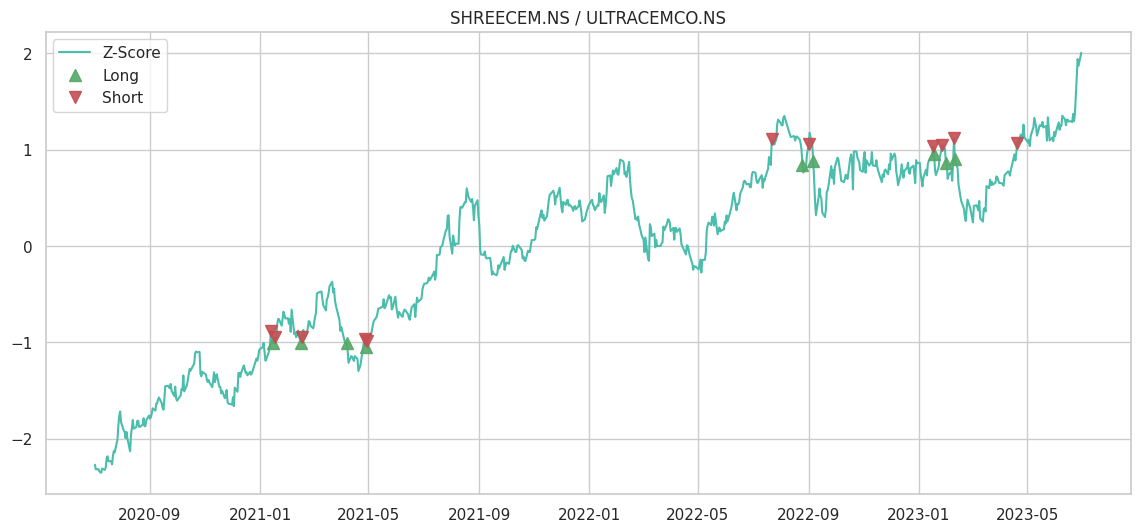

In [216]:
plot_pair_trades(trade_signals)

In [217]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price1'], c='#4abdac')
  u1 = bx.plot(signals['price1'][signals['position1'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['price1'][signals['position1'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[0])
  plt.legend(['Price', 'Long', 'Short'])

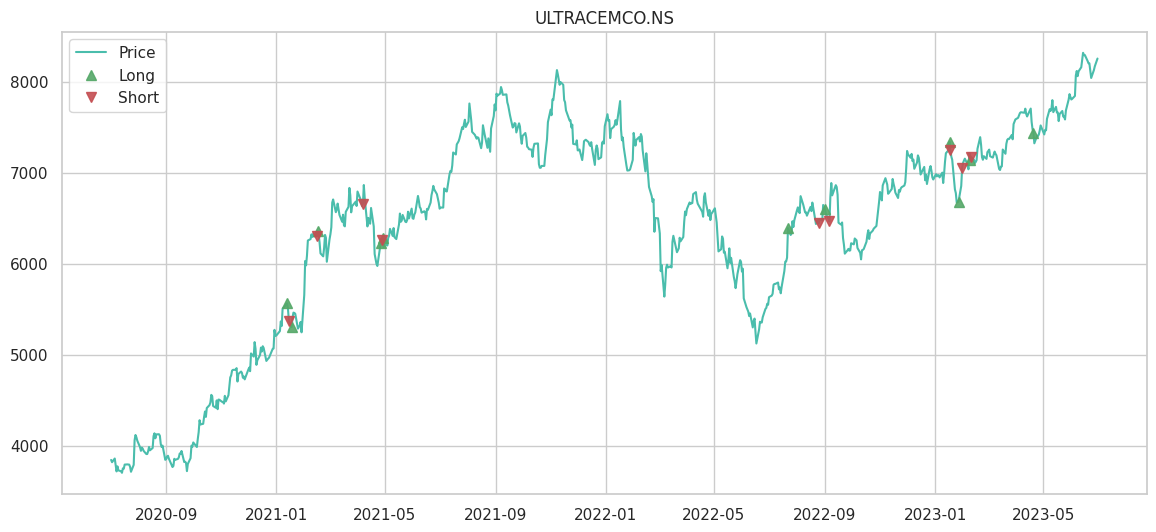

In [218]:
plot_trades_1(trade_signals)

In [219]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price2'], c='#4abdac')
  u1 = bx.plot(signals['price2'][signals['position2'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['price2'][signals['position2'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[1])
  plt.legend(['Price', 'Long', 'Short'])

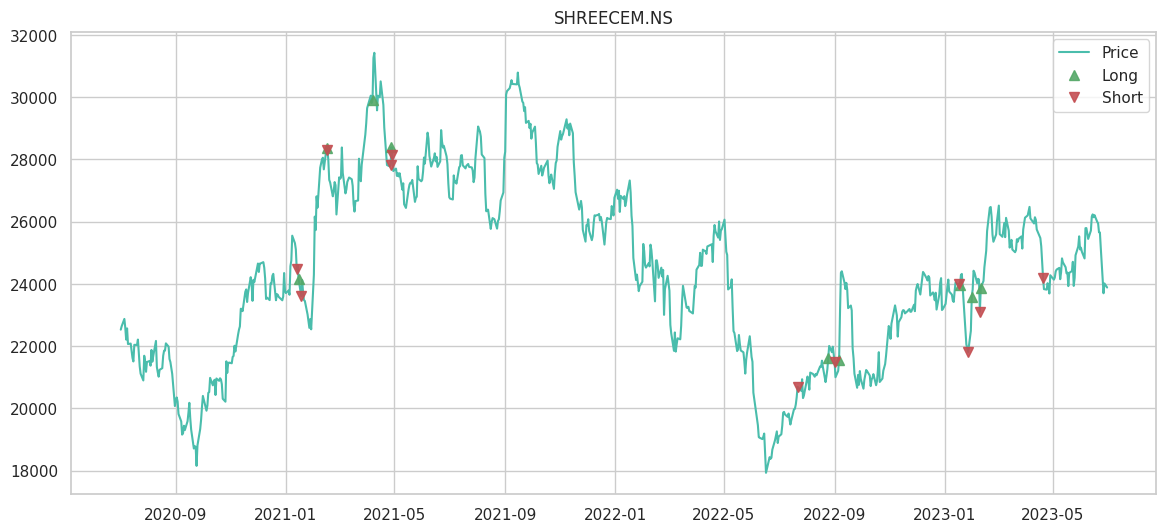

In [220]:
plot_trades_2(trade_signals)

## **Portfolio Performance**

### **PnL Calculation**

In [221]:
def pnl_calculation(signals):

  initial_capital = 100000

  # Shares to buy for each stock
  shares1 = initial_capital// (signals['price1'][0])
  shares2 = initial_capital// (signals['price2'][0])

  #PnL for stock 1
  portfolio = pd.DataFrame()
  portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
  portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

  # PnL for stock 2
  portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
  portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()

  # Total PnL
  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio


In [222]:
portfolio = pnl_calculation(trade_signals)
portfolio.head()

,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2020-07-03,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0
2020-07-06,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0
2020-07-07,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0
2020-07-08,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0
2020-07-09,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0


In [223]:

def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])

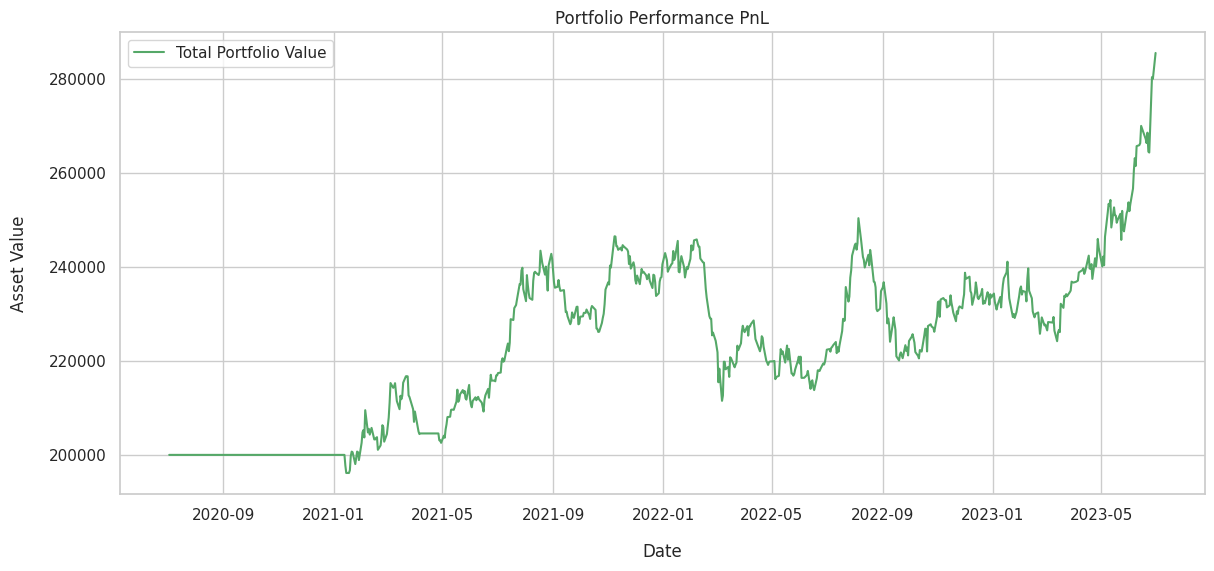

In [224]:
plot_portfolio_value(portfolio)

## **Portfolio Returns**

In [225]:

def calculate_cagr(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns


In [226]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))


Number of trading days =  744
CAGR = 12.810%


Returns are also compared to a benchmark to assess the performance of the trading strategy in comparison to the overall market. For the purpose of this strategy, the NIFTY BANK index is taken as a benchmark.

[*********************100%%**********************]  1 of 1 completed


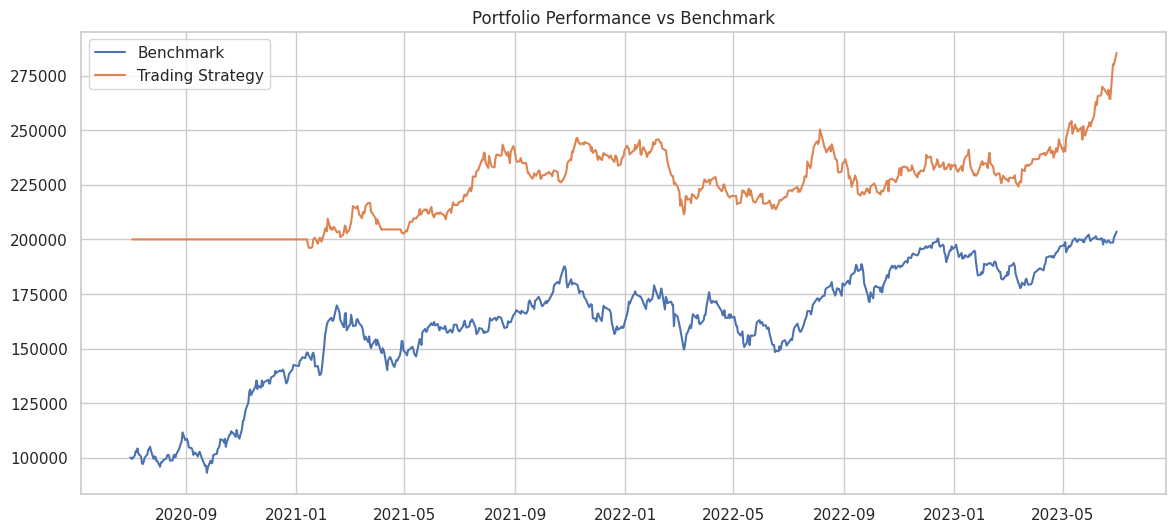

In [227]:
index = yf.download('^NSEBANK', start = '2020-07-01', end = '2023-07-01')['Adj Close']
shares = 100000/index[0]

plt.figure(figsize = (14, 6))
plt.plot(index*shares)
plt.plot(portfolio['total'])
plt.title('Portfolio Performance vs Benchmark')
plt.legend(['Benchmark', 'Trading Strategy'])


In [228]:
cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
print("CAGR of NIFTY Bank:", np.round(cagr_index*100, 3), "%")
cagr_portfolio = (portfolio['total'][-1] / portfolio['total'][0]) ** (252/len(portfolio)) - 1
print("CAGR of trading strategy:", np.round(cagr_portfolio*100, 3), "%")

CAGR of NIFTY Bank: 27.23 %
CAGR of trading strategy: 12.81 %
